# Start from here if git repo exists (or if you restart runtime)

In [1]:
# Checkout to the branch containing the correct code
# (Currently old_method_all_perm). See the output to be sure
%cd mmhealth_postprocess
!git checkout old_method_all_perm
!git branch

/home/pradyumnachari/Documents/ImplicitPPG/mmhealth_postprocess
Already on 'old_method_all_perm'
Your branch is up to date with 'origin/old_method_all_perm'.
  main
* old_method_all_perm


In [2]:
# !pip install imageio-ffmpeg

# Python code starts here

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import h5py
from tqdm import tqdm
import imageio
import scipy

from uni_modal.cameras.PhysNet_NewLoader.heart_rate_extract import prpsd, getErrors

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

#seeds
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

Running on device: cuda:0


In [4]:
import math
import torch.nn as nn
from torch.nn.modules.utils import _triple
import torch

from __future__ import print_function, division
from torchvision import transforms

class SNRLossOnPreComputedAndWindowedFFT_base(nn.Module):
    def __init__(self, start_idx, window_fraction=0.02, device=torch.device('cpu')):
        super(SNRLossOnPreComputedAndWindowedFFT_base, self).__init__()
        self.start_idx = start_idx
        self.window_fraction = window_fraction
        self.device = device
        
    def forward(self, outputs: torch.Tensor, targets: torch.Tensor):
        assert outputs.shape == targets.shape, "The predicted output and the target labels have different shapes"
        if not outputs.is_cuda:
            torch.backends.mkl.is_available()
        # The window length for the calculating the singal to noise ratio of the output's PSD
        # Here we take 5% in tota, i.e. 2.5% on both sides
        window_size_base_harmonic = int(self.window_fraction * targets.shape[1]) + 1

        # Get the strongest peaks from the output, i.e. the heart beats from the PSD of the targets
        Y2 = torch.abs(targets) ** 2
        HRixs = torch.argmax(Y2,axis=1)

        # get the PSD of the outputs of the neural network
        X2 = torch.abs(outputs) ** 2

        # calc SNR for each batch
        losses = torch.empty((X2.shape[0],), dtype=torch.float32)
        for count, ref_idx in enumerate(HRixs):
            # Compute the power around the heart beat idx and its fist harmonic => Signal
            base_start = max([0, ref_idx - window_size_base_harmonic])
            base_end   = ref_idx + window_size_base_harmonic + 1
            harmonic_start = max([0, (2 * ref_idx) + self.start_idx - window_size_base_harmonic])
            harmonic_end   = (2 * ref_idx) + self.start_idx + window_size_base_harmonic + 1
            pulse_freq_amp = torch.sum(X2[count, base_start : base_end])#+torch.sum(X2[count, harmonic_start : harmonic_end])
            # Compute the power outisde the above windows => Noise
            other_avrg = torch.sum(X2[count, :base_start]) + torch.sum(X2[count, base_end:])#+torch.sum(X2[count, base_end : harmonic_start]) + torch.sum(X2[count, harmonic_end:]))
            # Take the SNR loss in decibels
            losses[count] = -10*torch.log10(pulse_freq_amp/(other_avrg+1e-7))
        losses.to(self.device)
        return torch.mean(losses)



'''
Code of 'Remote Photoplethysmograph Signal Measurement from Facial Videos Using Spatio-Temporal Networks' 
By Zitong Yu, 2019/05/05
If you use the code, please cite:
@inproceedings{yu2019remote,
    title={Remote Photoplethysmograph Signal Measurement from Facial Videos Using Spatio-Temporal Networks},
    author={Yu, Zitong and Li, Xiaobai and Zhao, Guoying},
    booktitle= {British Machine Vision Conference (BMVC)},
    year = {2019}
}
Only for research purpose, and commercial use is not allowed.
MIT License
Copyright (c) 2019 
      How to use it
    #1. Inference the model
    rPPG, x_visual, x_visual3232, x_visual1616 = model(inputs)
    
    #2. Normalized the Predicted rPPG signal and GroundTruth BVP signal
    rPPG = (rPPG-torch.mean(rPPG)) /torch.std(rPPG)	 	# normalize
    BVP_label = (BVP_label-torch.mean(BVP_label)) /torch.std(BVP_label)	 	# normalize
    
    #3. Calculate the loss
    loss_ecg = Neg_Pearson(rPPG, BVP_label)
'''
########################################




class Neg_Pearson2(torch.nn.Module):    # Pearson range [-1, 1] so if < 0, abs|loss| ; if >0, 1- loss
    def __init__(self):
        super(Neg_Pearson2,self).__init__()

        self.epsilon = 1e-2

        return
    def forward(self, preds, labels):       # tensor [Batch, Temporal]
        loss = 0
        for i in range(preds.shape[0]):
            # print(labels[i])
            # print(preds[i])
            x = normalize_signal2(preds[i])
            y = normalize_signal2(labels[i])

            sum_x = torch.sum(x)                # x
            sum_y = torch.sum(y)               # y
            sum_xy = torch.sum(x*y)         # xy
            sum_x2 = torch.sum(torch.pow(x,2))  # x^2
            sum_y2 = torch.sum(torch.pow(y,2)) # y^2
            N = preds.shape[1]
            pearson = (N*sum_xy - sum_x*sum_y)/(torch.sqrt((N*sum_x2 - torch.pow(sum_x,2)+self.epsilon)*(N*sum_y2 - torch.pow(sum_y,2)+self.epsilon)))

            # print(torch.sqrt((N*sum_x2 - torch.pow(sum_x,2))), (N*sum_y2 - torch.pow(sum_y,2)))
            # print(pearson, end=" ")
            #if (pearson>=0).data.cpu().numpy():    # torch.cuda.ByteTensor -->  numpy
            #    loss += 1 - pearson
            #else:
            #    loss += 1 - torch.abs(pearson)
            
            loss += (1 - pearson)**2
            
        # print(loss) 
        loss = loss/preds.shape[0]
        return loss


def normalize_signal2(sig):
    return (sig-torch.mean(sig)) / (torch.std(sig)+1.00e-6)

In [5]:
##UNIMODAL DATALOADER
class RppgData2(Dataset):
    def __init__(self, datapath, datapaths, recording_str, video_length = 900, num_segments = 3, frame_length = 300, fs=30, l_freq_bpm=45, u_freq_bpm=180, fft_resolution = 48) -> None:
        #REMOVE RECORDING STRING
        #TODO TODO this line is temporary 
        self.ppg_offset = 25
        self.num_samps = 30
        #Data structure for videos
        self.video_length = video_length
        self.num_segments = num_segments
        self.part_length = int(video_length/num_segments)
        self.datapath = datapath

        self.fs = fs
        self.l_freq_bpm = l_freq_bpm
        self.u_freq_bpm = u_freq_bpm
        self.fft_resolution = fft_resolution
        # TODO TODO TODO : To be corrected
        # The PPG files for the RGB are stored as rgbd_ppg and not rgbd_rgb_ppg

        #load videos and signals
        self.video_list = datapaths
        self.signal_list = []
        self.item_list = []
        #load signals
        remove_folders = []
        for folder in self.video_list:
            file_path1 = os.path.join(self.datapath, 'residual_0_'+folder+'.npy')
            file_path2 = os.path.join(self.datapath, 'residual_300_'+folder+'.npy')
            file_path3 = os.path.join(self.datapath, 'residual_600_'+folder+'.npy')
            # print(file_path)
            if(os.path.exists(file_path1) and os.path.exists(file_path2) and os.path.exists(file_path3)):
                #Load the time series signal
                avg_temp = np.zeros((3,self.video_length))
                for frame_start in range(self.num_segments):
                    vid = np.load(os.path.join(self.datapath, 'residual_'+str(int(frame_start*self.part_length))+'_'+folder+'.npy'))
                    temp = np.mean(np.mean(vid,axis=1),axis=1)
                    temp = np.transpose(temp,(1,0))

                    avg_temp[:,frame_start*self.part_length:(frame_start+1)*self.part_length] = temp

                    # for img_idx in range(self.part_length):
                    #     image = vid.get_data(img_idx) #frame_start*self.part_length+

                    #     avg_temp[:,int(frame_start*self.part_length+img_idx)] = np.mean(np.mean(image,axis=0),axis=0)

                # avg_temp = (avg_temp-np.mean(avg_temp,axis=1,keepdims=True))/np.std(avg_temp,axis=1,keepdims=True)
                self.item_list.append(avg_temp)

                if(os.path.exists(os.path.join(self.datapath, f"{folder}.npy"))):
                    signal = np.load(os.path.join(self.datapath, f"{folder}.npy"))
                    mean_temp = np.mean(signal)
                    std_temp = np.std(signal)
                    signal = (signal - mean_temp)/std_temp
                    self.signal_list.append(signal[self.ppg_offset:])
                else:
                    print(folder, "ppg doesn't exist.")
                    remove_folders.append(folder)
            else:
                print(folder, " doesn't exist.")
                remove_folders.append(folder)

        for i in remove_folders:
            self.video_list.remove(i)    
            print("removed", i)
        #process_vital_signs
        ### TODO TODO TODO detrend signals
        self.signal_list = np.array(self.signal_list)

        self.item_list = np.array(self.item_list)
        # Create a list of video number and valid frame nuber to extract the datad from.
        self.frame_length = frame_length
        self.video_nums = np.arange(0, len(self.video_list))
        # self.frame_nums = np.arange(0, self.part_length - frame_length - self.ppg_offset)

        #create all possible sampling combinations and put in self.all_idxs
        self.all_idxs = []
        for num in self.video_nums:
            cur_frame_nums = np.random.choice(np.arange(self.video_length - self.frame_length - self.ppg_offset), size=self.num_samps, replace=False)
            # cur_frame_nums = np.random.randint(
            #   low=0, high = self.video_length - self.frame_length - self.ppg_offset, size = self.num_samps)
            
            for cur_frame_num in cur_frame_nums:
                self.all_idxs.append((num,cur_frame_num))


        #FFT parts
        seq_len = self.frame_length*self.fft_resolution
        
        freqs_bpm = np.fft.fftfreq(int(seq_len), d=1/self.fs) * 60
        self.l_freq_idx = np.argmin(np.abs(freqs_bpm - self.l_freq_bpm))
        self.u_freq_idx = np.argmin(np.abs(freqs_bpm - self.u_freq_bpm))
        print(self.l_freq_idx, self.u_freq_idx)
        print(freqs_bpm[self.l_freq_idx], freqs_bpm[self.u_freq_idx])
        assert self.l_freq_idx < self.u_freq_idx

            
            
    def __len__(self):
        return int(len(self.all_idxs))
    def __getitem__(self, idx):
        video_number, frame_start = self.all_idxs[idx]
        # video_number = self.video_nums[idx]
        # frame_start = np.random.choice(self.frame_nums)
        #Get video_frames

        item = self.item_list[int(video_number)][:,int(frame_start):int(frame_start+self.frame_length)]
        item = (item-np.mean(item,axis=1,keepdims=True))/np.std(item,axis=1,keepdims=True)
        #Get signal
        item_sig = self.signal_list[int(video_number)][int(frame_start):int(frame_start+self.frame_length)]

        # print(item.shape)
        # print(item_sig.shape)
        
        # if self.compute_fft:
        # n_curr = len(item_sig) * self.fft_resolution
        # fft_gt  = np.abs(np.fft.fft(item_sig, n=int(n_curr), axis=0))
        # fft_gt = fft_gt / np.max(fft_gt, axis=0)
        
        # fft_est = np.abs(np.fft.fft(item, n=int(n_curr), axis=1))
        # fft_est = fft_est / np.max(fft_est)#np.max(fft_est, axis=1)
        # fft_est = fft_est[:,self.l_freq_idx : self.u_freq_idx + 1]

        return item, item_sig
        
        
        # #Patch for torch constructor not accepting uint16 datatypes
        # if(item.dtype == np.uint16):
        #     item = item.astype(np.int32)
        # return np.array(item), np.array(item_sig)


    # def lowPassFilter(self, BVP, butter_order=4):
    #     [b, a] = sig.butter(butter_order, [self.l_freq_bpm/60, self.u_freq_bpm/60], btype='bandpass', fs = self.fs)
    #     filtered_BVP = sig.filtfilt(b, a, np.double(BVP))
    #     return filtered_BVP

In [6]:
def extract_video(path, cur_session):
    length_seg = 300
    vid = np.zeros((3,900))
    for j in range(3): #number of segments
        video_rd = np.load(os.path.join(path, 'residual_'+str(j*length_seg)+'_'+cur_session+'.npy'))

        temp = np.mean(np.mean(video_rd,axis=1),axis=1)
        temp = np.transpose(temp,(1,0))
        vid[:,j*length_seg:(j+1)*length_seg] = temp

#             vid.append(np.mean(np.mean(image,axis=0),axis=0))

    return vid #should be of shape 3x900

##Eval model
def eval_model(root_dir, session_names, model, in_frames=64, 
               hr_window_size = 300, stride = 128, video_fps = 30, ppg_offset = 25, fft_resolution=48):
    model.eval()#!!!
    video_samples = []
    for cur_session in session_names:
        video_sample = {"video_path" : root_dir, "cur_session" : cur_session}
        video_samples.append(video_sample)


    #Get indices for FFT
    #TODO: band limit dependencies. clean this up
    l_freq_bpm = 45
    u_freq_bpm = 180

    for cur_video_sample in tqdm(video_samples):
        cur_video_path = cur_video_sample["video_path"]
        cur_session = cur_video_sample["cur_session"]

        frames = extract_video(path=cur_video_path, cur_session=cur_session) # (900, 128, 128, 3)
        target = np.load(os.path.join(cur_video_path, cur_session+'.npy'))
        ##Apply offset to target
        target = target[ppg_offset:]



        #Normalize target
        target = (target-np.mean(target,axis=0,keepdims=True))/np.std(target,axis=0,keepdims=True)

        #get the start indices
        start_indices = np.arange(0,frames.shape[-1]+1-ppg_offset-hr_window_size,stride)
        

        batched_ip = []
        batched_tgt = []

        for ix in start_indices:
            temp_ip = frames[:,ix:ix+hr_window_size]
            temp_ip = (temp_ip-np.mean(temp_ip,axis=1,keepdims=True))/np.std(temp_ip,axis=1,keepdims=True)
            #Take FFT
            

            batched_ip.append(temp_ip)


            temp_tgt = target[ix:ix+hr_window_size]
            
            batched_tgt.append(temp_tgt)

        batched_ip = torch.Tensor(np.array(batched_ip)).to(device)
        # batched_tgt = torch.Tensor(np.array(batched_tgt)).to(device)
        batched_tgt = np.array(batched_tgt) #B,fft_size


        # Potential High GPU usage
        # A batch_size of approx 14
        

        with torch.no_grad():
            est_ppg_ffts = model(batched_ip)
            # (14, 64)
            est_ppg_ffts = est_ppg_ffts.squeeze().cpu().numpy() #Size: B,fft_size

       # Save
        cur_video_sample['est_ppg_ffts'] = est_ppg_ffts
        cur_video_sample['gt_ppg_ffts'] = batched_tgt
    print('All finished!')

    #Estimate using waveforms
    mae_list = []
    all_hr_est = []
    all_hr_gt = []
    for index, cur_video_sample in enumerate(video_samples):
        cur_video_path = cur_video_sample['video_path']
        # print('Video:', cur_video_path)
        est_ppg_ffts = cur_video_sample['est_ppg_ffts']
        # Load GT
        gt_ppg_ffts = cur_video_sample['gt_ppg_ffts']

        #Just need to iterate over batch dimension and

        # Get est HR for each window
        hr_est_temp = []
        hr_gt_temp = []
        for ixx in range(est_ppg_ffts.shape[0]):
            est_hr = prpsd2(est_ppg_ffts[ixx], 30, 45, 150, BUTTER_ORDER=6, DETREND=False)
            gt_hr = prpsd2(gt_ppg_ffts[ixx], 30, 45, 150, BUTTER_ORDER=6, DETREND=False)
            hr_est_temp.append(est_hr)
            hr_gt_temp.append(gt_hr)

        hr_est_windowed = np.array([hr_est_temp])
        hr_gt_windowed = np.array(hr_gt_temp)
        all_hr_est.append(hr_est_temp)
        all_hr_gt.append(hr_gt_temp)

        # Errors
        RMSE, MAE, MAX, PCC = getErrors(hr_est_windowed, hr_gt_windowed)

        mae_list.append(MAE)
    print('Mean MAE:', np.mean(np.array(mae_list)))
    return np.array(mae_list), (all_hr_est, all_hr_gt)


In [7]:
def prpsdFFT(BVP, FS, LL_PR, UL_PR, WIN_SZ, FFT_RES):
    #BVP has shape (k,)
    
    l_freq_bpm = LL_PR
    u_freq_bpm = UL_PR
    seq_len = WIN_SZ*FFT_RES
    freqs_bpm = np.fft.fftfreq(int(seq_len), d=1/FS) * 60

    base_ix = np.argmin(np.abs(freqs_bpm - l_freq_bpm))
    #We can now index the above to get the final index
    #Input is a PSD. We just find the argmax
    max_ix = np.argmax(BVP)

    hr = freqs_bpm[base_ix+max_ix]
            
    return hr

def prpsd2(BVP, FS, LL_PR, UL_PR, BUTTER_ORDER=6, DETREND=False, PlotTF=False, FResBPM = 0.1):
    '''
    Estimates pulse rate from the power spectral density a BVP signal
    
    Inputs
        BVP              : A BVP timeseries. (1d numpy array)
        fs               : The sample rate of the BVP time series (Hz/fps). (int)
        lower_cutoff_bpm : The lower limit for pulse rate (bpm). (int)
        upper_cutoff_bpm : The upper limit for pulse rate (bpm). (int)
        butter_order     : Order of the Butterworth Filter. (int)
        detrend          : Detrend the input signal. (bool)
        FResBPM          : Resolution (bpm) of bins in power spectrum used to determine pulse rate and SNR. (float)
    
    Outputs
        pulse_rate       : The estimated pulse rate in BPM. (float)
    
    Daniel McDuff, Ethan Blackford, January 2019
    Copyright (c)
    Licensed under the MIT License and the RAIL AI License.
    '''
    from scipy.signal import butter
    from scipy import signal
    import numpy as np

    N = (60*FS)/FResBPM

    # Detrending + nth order butterworth + periodogram
#     if DETREND:
#         BVP = detrend(np.cumsum(BVP), 100)
#     if BUTTER_ORDER:
    [b, a] = signal.butter(BUTTER_ORDER, [LL_PR/60, UL_PR/60], btype='bandpass', fs = FS)
    
    BVP = signal.filtfilt(b, a, np.double(BVP))
    
    # Calculate the PSD and the mask for the desired range
#     if detrend:
    F, Pxx = signal.periodogram(x=BVP,  nfft=N, fs=FS, detrend=False);  
#     else:
#         F, Pxx = signal.periodogram(x=BVP, window=np.hanning(len(BVP)), nfft=N, fs=FS)
    FMask = (F >= (LL_PR/60)) & (F <= (UL_PR/60))
    
    # Calculate predicted pulse rate:
    FRange = F * FMask
    PRange = Pxx * FMask
    MaxInd = np.argmax(PRange)
    pulse_rate_freq = FRange[MaxInd]
    pulse_rate = pulse_rate_freq*60

    # Optionally Plot the PSD and peak frequency
    if PlotTF:
        # Plot PSD (in dB) and peak frequency
        plt.figure()
        plt.plot(F, 10 * np.log10(Pxx))
        plt.plot(pulse_rate_freq, 10 * np.log10(PRange[MaxInd]),'ro')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power (dB)')
        plt.xlim([0, 4.5])
        plt.title('Power Spectrum and Peak Frequency')
            
    return pulse_rate

In [8]:
import pickle

destination_folder = "/home/pradyumnachari/Documents/ImplicitPPG/ResidualData/NpyRes/"

fitz_labels_path = "/home/pradyumnachari/Documents/ImplicitPPG/SIGGRAPH_Data/fitzpatrick_labels.pkl"

with open("/home/pradyumnachari/Documents/ImplicitPPG/SIGGRAPH_Data/train_val_test_folds_ld_max.pkl", "rb") as fpf:
        out = pickle.load(fpf)

train = out[3]["train"]
val = out[3]["val"]
test = out[3]["test"]

print(train)
print(test)
print(len(train), len(test), len(val))
#Dataset
dataset = RppgData2(datapath=destination_folder, datapaths=train, recording_str="rgbd_rgb")
dataset_val = RppgData2(datapath=destination_folder, datapaths=val, recording_str="rgbd_rgb")
dataset_test = RppgData2(datapath=destination_folder, datapaths=test, recording_str="rgbd_rgb")

print(len(train), len(test), len(val))

['v_7_1', 'v_7_2', 'v_7_3', 'v_7_4', 'v_7_5', 'v_7_6', 'v_95_1', 'v_95_2', 'v_95_3', 'v_95_4', 'v_95_5', 'v_95_6', 'v_11_1', 'v_11_2', 'v_11_3', 'v_11_4', 'v_11_5', 'v_11_6', 'v_15_1', 'v_15_2', 'v_15_3', 'v_15_4', 'v_15_5', 'v_15_6', 'v_32_2', 'v_32_3', 'v_32_4', 'v_32_5', 'v_32_6', 'v_1_1', 'v_1_2', 'v_1_3', 'v_1_4', 'v_1_5', 'v_1_6', 'v_14_1', 'v_14_2', 'v_14_3', 'v_14_4', 'v_14_5', 'v_14_6', 'v_14_7', 'v_5_1', 'v_5_2', 'v_5_3', 'v_5_4', 'v_5_5', 'v_5_6', 'v_40_1', 'v_40_2', 'v_40_3', 'v_40_4', 'v_40_5', 'v_40_6', 'v_23_1', 'v_23_2', 'v_23_3', 'v_23_4', 'v_23_5', 'v_23_6', 'v_53_1', 'v_53_2', 'v_53_3', 'v_53_4', 'v_53_5', 'v_53_6', 'v_83_1', 'v_83_2', 'v_83_3', 'v_83_4', 'v_83_5', 'v_83_6', 'v_57_1', 'v_57_2', 'v_57_3', 'v_57_4', 'v_57_5', 'v_57_6', 'v_45_1', 'v_45_2', 'v_45_3', 'v_45_4', 'v_45_5', 'v_45_6', 'v_60_1', 'v_60_2', 'v_60_3', 'v_60_4', 'v_60_5', 'v_60_6', 'v_90_1', 'v_90_2', 'v_90_3', 'v_90_4', 'v_90_5', 'v_90_6', 'v_19_1', 'v_19_2', 'v_19_3', 'v_19_4', 'v_19_5', 'v_19_6

In [9]:
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers = 2)
test_dataloader  = DataLoader(dataset_test, batch_size=64, shuffle=True, num_workers = 2)

In [10]:
# print(dataset.vital_mean, dataset.vital_std)

113 107
(3, 300) float64 (300,)
(3, 300) (300,)


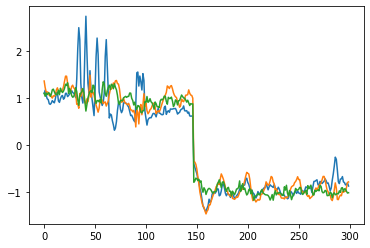

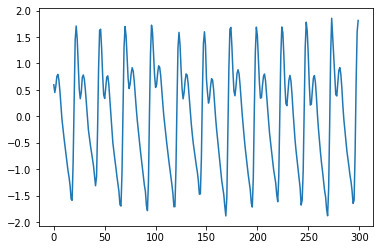

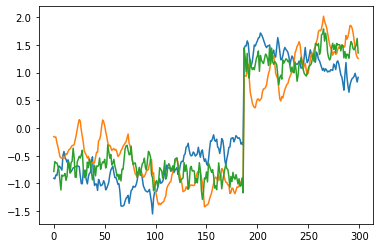

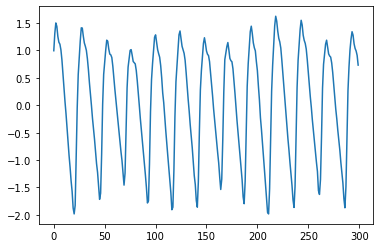

In [11]:
print(len(train_dataloader), len(test_dataloader))

# Visualize some examples
for i in range(len(dataset)):
    train_batch, train_batch_sig = dataset[i]
    break

print(train_batch.shape, train_batch.dtype, train_batch_sig.shape)

plt.figure()
plt.plot(np.transpose(train_batch, (1,0)))
plt.figure()
plt.plot(train_batch_sig)

for i in range(len(dataset_test)):
    test_batch, test_batch_sig = dataset_test[i]
    break

print(test_batch.shape, test_batch_sig.shape)

plt.figure()
plt.plot(np.transpose(test_batch, (1,0)))
plt.figure()
plt.plot(test_batch_sig)

In [12]:
#Set Checkpoint Directory
colab_filename = 'fold4_AverageTimeseries_residual_lam3_fixedSamp'
ckpt_parent_path = '/home/pradyumnachari/Documents/ImplicitPPG/checkpoints'
assert os.path.exists(ckpt_parent_path), "Check folder to save checkpoint"
ckpt_path = os.path.join(ckpt_parent_path, colab_filename)
os.makedirs(ckpt_path, exist_ok=True)
print(f"Checkpoints will be saved in {ckpt_path}")

Checkpoints will be saved in /home/pradyumnachari/Documents/ImplicitPPG/checkpoints/fold4_AverageTimeseries_residual_lam3_fixedSamp


In [13]:
#Check if Checkpoints exist
paths = os.listdir(ckpt_path)
if(len(paths) > 0):
    paths.sort() 
    last_checkpoint = os.path.join(ckpt_path, paths[-1])

    print("Checkpoints already exist-")
    print(paths)
    print("Last checkpoint set to -")
    print(last_checkpoint)
else:
  print("No checkpoints found, starting from scratch!")
    

No checkpoints found, starting from scratch!


In [14]:
from torch import nn
class PlethRegressor(nn.Module):
    def __init__(self, inp_len, out_len, latent=512):
        super(PlethRegressor, self).__init__()
        self.inp_len = inp_len
        self.latent = latent
        self.out_len = out_len
        self.Enc1 = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size=9, stride=1,padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.Enc2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=9, stride=1,padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.Enc3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=9, stride=1,padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.Enc4 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=9, stride=1,padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        
        self.Dec1 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=9, stride=1,padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.Dec2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=9, stride=1,padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.Dec3 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=9, stride=1,padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.Dec4 = nn.Sequential(
            nn.Conv1d(64, 16, kernel_size=9, stride=1,padding=4),
            nn.BatchNorm1d(16),
            nn.ReLU(),
        )
        self.FinalLayer   = nn.Conv1d(16, 1, kernel_size=1, stride=1)
    def forward(self, inp):
        inp = self.Enc1(inp)
        inp = self.Enc2(inp)
        inp = self.Enc3(inp)
        inp = self.Enc4(inp)
        inp = self.Dec1(inp)
        inp = self.Dec2(inp)
        inp = self.Dec3(inp)
        inp = self.Dec4(inp)
        output_signal = self.FinalLayer(inp)
        return torch.squeeze(output_signal, 1)

class PlethRegressorLinear(nn.Module):
    def __init__(self, inp_len, out_len, latent=512):
        super(PlethRegressorLinear, self).__init__()
        self.inp_len = inp_len
        self.latent = latent
        self.out_len = out_len
        self.Enc1 = nn.Sequential(
            nn.Linear(inp_len*3, latent),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.Enc2 = nn.Sequential(
            nn.Linear(latent, latent),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.Enc3 = nn.Sequential(
            nn.Linear(latent, latent),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.Enc4 = nn.Sequential(
            nn.Linear(latent, latent),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        
        self.Dec1 = nn.Sequential(
            nn.Linear(latent, latent),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.Dec2 = nn.Sequential(
            nn.Linear(latent, latent),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.Dec3 = nn.Sequential(
            nn.Linear(latent, latent),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.Dec4 = nn.Sequential(
            nn.Linear(latent, latent),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.FinalLayer   = nn.Linear(latent, out_len)
    def forward(self, inp):
        inp = torch.reshape(inp,(inp.shape[0],-1))
        inp = self.Enc1(inp)
        inp = self.Enc2(inp)
        inp = self.Enc3(inp)
        inp = self.Enc4(inp)
        inp = self.Dec1(inp)
        inp = self.Dec2(inp)
        inp = self.Dec3(inp)
        inp = self.Dec4(inp)
        output_signal = self.FinalLayer(inp)
        return output_signal#torch.squeeze(output_signal, 1)

In [15]:
import math
import torch.nn as nn
from torch.nn.modules.utils import _triple
import torch as tr
import pdb

class SNRLoss_dB_Signals(nn.Module):
  def __init__(self):
    super(SNRLoss_dB_Signals, self).__init__()
  def forward(self, outputs: tr.Tensor, targets: tr.Tensor, Fs=30):
    device = outputs.device
    if not outputs.is_cuda:
      torch.backends.mkl.is_available()
    N = 600#3*outputs.shape[-1] #1000#
    N_samp = outputs.shape[-1]
    #print(N)
    pulse_band = tr.tensor([45/60., 180/60.], dtype=tr.float32).to(device)
    wind_sz = int(1*N/64)#20

    f = tr.linspace(0, Fs/2, int(N/2)+1, dtype=tr.float32).to(device)
    # print(60*(f[1]-f[0]))
    min_idx = tr.argmin(tr.abs(f - pulse_band[0]))
    max_idx = tr.argmin(tr.abs(f - pulse_band[1]))
    # print(min_idx,max_idx)

    outputs = outputs.view(-1, N_samp)
    targets = targets.view(-1, N_samp)

    #Generate GT heart indices from GT signals
    Y = torch.fft.rfft(targets, n=N, dim=1, norm='forward')
    Y2 = tr.abs(Y) ** 2
    HRixs = tr.argmax(Y2[:,min_idx:max_idx],axis=1)+min_idx

    #print(outputs.shape)
    X = torch.fft.rfft(outputs, n=N, dim=1, norm='forward')

    P1 = tr.abs(X) ** 2
    # print(HRixs)
    # plt.figure()
    # plt.plot(f,P1[0])
    # plt.plot(f[HRixs[0]],P1[0,HRixs[0]],'rx')
    # plt.plot(f[HRixs[0]-wind_sz],P1[0,HRixs[0]-wind_sz],'gx')
    # plt.plot(f[HRixs[0]+wind_sz],P1[0,HRixs[0]+wind_sz],'gx')
    # plt.grid('on')
    # plt.show()

    # calc SNR for each batch
    losses = tr.empty((X.shape[0],), dtype=tr.float32)#.to(device)
    for count, ref_idx in enumerate(HRixs):
      pulse_freq_amp = tr.sum(P1[count, ref_idx-wind_sz:ref_idx+wind_sz])+tr.sum(P1[count, 2*ref_idx-wind_sz:2*ref_idx+wind_sz])
      # other_avrg = (tr.sum(P1[count, min_idx:ref_idx-wind_sz]) + tr.sum(P1[count, ref_idx+wind_sz:max_idx]))
      other_avrg = (tr.sum(P1[count, min_idx:ref_idx-wind_sz])+tr.sum(P1[count, ref_idx+wind_sz:2*ref_idx-wind_sz]) + tr.sum(P1[count, 2*ref_idx+wind_sz:max_idx]))
      # print(pulse_freq_amp,other_avrg)
      losses[count] = -10*tr.log10(pulse_freq_amp/(other_avrg+1e-7))
    losses.to(device)
    return tr.mean(losses)

In [16]:
from tqdm import tqdm
#CONTEXT PATH
PATH = os.path.join(os.getcwd(), f"{ckpt_path}/latest_context.pth")
model = PlethRegressor(inp_len=300, out_len=300).to(device)
# model.load_state_dict(torch.load(last_checkpoint))
loss_fn  = Neg_Pearson2()
loss_fn2  = SNRLoss_dB_Signals()#Neg_Pearson()

lam = 3

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

# Train configurations
epochs = 10
checkpoint_period = 1
epoch_start = 1
mae_best_loss = 1000
# if os.path.exists(PATH):
#     print('Context checkpoint exists. Loading state dictionaries.')
#     checkpoint = torch.load(PATH)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     epoch_start = checkpoint['epoch']
#     epoch_start+=1

for epoch in range(epoch_start, epochs+1):
    # Training Phase
    loss_train = 0
    no_batches = 0
    # print("Starting Epoch: {}".format(epoch))
    for batch, (imgs, signal) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        model.train()
        # Convert to the appropriate format and mount on the specified device
        imgs = imgs.float().to(device)
        signal = signal.float().to(device)

        # Predict the PPG signal and find ther loss
        pred_signal = model(imgs)
        loss1 = loss_fn(pred_signal, signal)
        loss2 = loss_fn2(pred_signal, signal)
        loss = loss2+lam*loss1

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the total loss
        loss_train += loss.item()
        no_batches+=1

    # Save the model every few epochs
    if(epoch % checkpoint_period == 0):
        torch.save(model.state_dict(), os.path.join(os.getcwd(), f"{ckpt_path}/PhysNet_state_dict_{epoch}_epochs.pth"))
        #See if best checkpoint
        mae_loss_list, hrs = eval_model(root_dir=destination_folder, session_names=val, model=model)
        current_loss = np.mean(mae_loss_list) 
        if(current_loss < mae_best_loss):
            mae_best_loss = current_loss
            torch.save(model.state_dict(), os.path.join(os.getcwd(), f"{ckpt_path}/PhysNet_state_dict_best.pth"))
            print("Best checkpoint saved!")
        print("Saved Checkpoint!")

    print(f"Epoch: {epoch} ; Loss: {loss_train/no_batches:>7f}")
    #SAVE CONTEXT AFTER EPOCH
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

        

100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 11.65it/s]


All finished!
Mean MAE: 1.499696969696969
Best checkpoint saved!
Saved Checkpoint!
Epoch: 1 ; Loss: -13.082713


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 11.68it/s]


All finished!
Mean MAE: 1.6433333333333333
Saved Checkpoint!
Epoch: 2 ; Loss: -17.184459


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 12.17it/s]


All finished!
Mean MAE: 1.6881818181818187
Saved Checkpoint!
Epoch: 3 ; Loss: -19.362532


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 11.05it/s]


All finished!
Mean MAE: 1.8106060606060606
Saved Checkpoint!
Epoch: 4 ; Loss: -21.109943


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 11.53it/s]


All finished!
Mean MAE: 1.7242424242424246
Saved Checkpoint!
Epoch: 5 ; Loss: -22.797979


100%|███████████████████████████████████████████| 66/66 [00:06<00:00, 10.42it/s]


All finished!
Mean MAE: 1.881818181818182
Saved Checkpoint!
Epoch: 6 ; Loss: -23.763721


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 11.39it/s]


All finished!
Mean MAE: 1.9151515151515157
Saved Checkpoint!
Epoch: 7 ; Loss: -24.817703


100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 11.11it/s]


All finished!
Mean MAE: 1.890606060606061
Saved Checkpoint!
Epoch: 8 ; Loss: -25.695122


100%|███████████████████████████████████████████| 66/66 [00:07<00:00,  8.82it/s]


All finished!
Mean MAE: 2.175454545454546
Saved Checkpoint!
Epoch: 9 ; Loss: -25.994110


100%|███████████████████████████████████████████| 66/66 [00:07<00:00,  9.27it/s]


All finished!
Mean MAE: 1.7878787878787883
Saved Checkpoint!
Epoch: 10 ; Loss: -26.653675


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import copy
import sklearn.metrics

def eval_clinical_performance(hr_est, hr_gt, fitz_labels_path, session_names):
    l_m_d_arr = distribute_l_m_d(fitz_labels_path , session_names)
    l_m_d_arr = np.array(l_m_d_arr)
    #absolute percentage error
    # print(hr_gt.shape, hr_est.shape)
    apes = np.abs(hr_gt - hr_est)/hr_gt*100
    # print(apes)
    l_apes = np.reshape(apes[np.where(l_m_d_arr==1)], (-1))
    d_apes = np.reshape(apes[np.where(l_m_d_arr==2)], (-1))

    l_5 = len(l_apes[l_apes <= 5])/len(l_apes)*100 
    d_5 = len(d_apes[d_apes <= 5])/len(d_apes)*100
    
    l_10 = len(l_apes[l_apes <= 10])/len(l_apes)*100
    d_10 = len(d_apes[d_apes <= 10])/len(d_apes)*100

    print("AAMI Standard - L,D")
    print(l_10, d_10)




########################################### Performance ##################################################
def eval_performance(hr_est, hr_gt):
    hr_est = np.reshape(hr_est, (-1))
    hr_gt  = np.reshape(hr_gt, (-1))
    r = scipy.stats.pearsonr(hr_est, hr_gt)
    mae = np.sum(np.abs(hr_est - hr_gt))/len(hr_est)
    hr_std = np.std(hr_est - hr_gt)
    hr_rmse = np.sqrt(np.sum(np.square(hr_est-hr_gt))/len(hr_est))
    hr_mape = sklearn.metrics.mean_absolute_percentage_error(hr_est, hr_gt)

    return mae, hr_mape, hr_rmse, hr_std, r[0]

def eval_performance_bias(hr_est, hr_gt, fitz_labels_path, session_names):
    l_m_d_arr = distribute_l_m_d(fitz_labels_path , session_names)
    l_m_d_arr = np.array(l_m_d_arr)

    general_performance = eval_performance(hr_est, hr_gt)
    l_p = np.array(eval_performance(hr_est[np.where(l_m_d_arr == 1)], hr_gt[np.where(l_m_d_arr == 1)]))
    d_p = np.array(eval_performance(hr_est[np.where(l_m_d_arr == 2)], hr_gt[np.where(l_m_d_arr == 2)]))

    performance_diffs = np.array([l_p-d_p])
    performance_diffs = np.abs(performance_diffs)
    performance_max_diffs = performance_diffs.max(axis=0)

    print("General Performance")
    print(general_performance)
    print("Performance Max Differences")
    print(performance_max_diffs)
    print("Performance By Skin Tone")
    print("Light - ", l_p)
    print("Dark - ", d_p)

    return general_performance, performance_max_diffs



def eval_models_performance(list_of_errors, list_of_labels):
    err_arr = np.array(list_of_errors)
    err_str_arr = [['%0.3f' %x for x in y] for y in err_arr]

    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    fig.set_size_inches(fig_size[0], fig_size[1])
    ax.axis('off')
    ax.axis('tight')
    table = ax.table(cellText=err_str_arr, 
                    colLabels=["MAE", "RMSE", "STD", "MAPE", "Pearson Correlation"], 
                    rowLabels=list_of_labels)
    fig.tight_layout()
    ax.set_title(f'Performance Metrics', weight='bold', size=14, color='k')
    table.scale(1, 6)
    table.set_fontsize(20)
    plt.show()

from scipy.stats import wasserstein_distance
def eval_wasserstein(errors, fitz_labels_path, session_names):
    l_m_d_arr = distribute_l_m_d(fitz_labels_path , session_names)
    l_m_d_arr = np.array(l_m_d_arr)

    l_p = np.array(errors[np.where(l_m_d_arr == 1)[0]])
    d_p = np.array(errors[np.where(l_m_d_arr == 2)[0]])

    wass_distances = wasserstein_distance(l_p, d_p)
    print("Wasserstein L/D")
    print(wass_distances)
    print("Num Light:", len(l_p), "Num Dark", len(d_p))

    return wass_distances



############################################# Fairness ###################################################

def gen_cdf(data, cutoff_mae = 2.5):
    # sort the data:
    data_sorted = np.sort(data)
    # calculate the proportional values of samples
    p = (np.arange(len(data))+0.5)/len(data)

    return data_sorted, p

def gen_cdf_sp(data, freq_res=0.1, max_error = 100):
    #round to nearest freq_resolution
    data = np.round(data/freq_res)*freq_res
    data = np.sort(data)
    #count num in each freq_resolution
    data_counts = list(Counter(data).items())
    freqs = [i[0] for i in data_counts]
    counts = [i[1] for i in data_counts]
    counts_cum = np.cumsum(counts)
    sum_counts = np.sum(counts)
    cdf = [i / sum_counts for i in counts_cum]
    #add missing freqs
    i = 0
    #account for not having zero bin
    if(freqs[0] != 0):
        freqs.insert(0,0.00)
        cdf.insert(0,0.00)
    while len(freqs) != int(100/freq_res):
        if(len(freqs) > i):
            if(freqs[i] == freq_res*i):
                i += 1
            else:
                freqs.insert(i, freq_res*i)
                cdf.insert(i, cdf[i-1])
                # print(freqs[i], freq_res*i,cdf[i])
                i +=1
        else:
            # print(freqs[i], freq_res*i,cdf[i])
            freqs.insert(i, freq_res*i)
            cdf.insert(i, cdf[i-1])
            # print(freqs[i], freq_res*i,cdf[i])
            i +=1


    return freqs, cdf

def calc_sp_ks_test(cdf1, cdf2):
    cdf1 = np.array(cdf1)
    cdf2 = np.array(cdf2)
    max = np.max(np.abs(cdf1-cdf2))
    return max

def calc_sp_diff_expected(cdf1, cdf2, freqs):
    cdf1 = copy.deepcopy(cdf1)
    cdf2 = copy.deepcopy(cdf2)
    cdf1.insert(0,0)
    cdf2.insert(0,0)
    cdf1 = np.array(cdf1)
    cdf2 = np.array(cdf2)
    pdf1 = np.diff(cdf1)
    pdf2 = np.diff(cdf2)

    diff_pdf = pdf1-pdf2
    group_fairness_expectation = np.sum(diff_pdf * freqs)

    return group_fairness_expectation

def distribute_l_m_d(fitz_labels_path, session_names):
    with open(fitz_labels_path, "rb") as fpf:
        out = pickle.load(fpf)

    #mae_list
    #session_names
    sess_w_fitz = []
    fitz_dict = dict(out)
    l_m_d_arr = []
    for i, sess in enumerate(session_names):
        pid = sess.split("_")
        pid = pid[0] + "_" + pid[1]
        fitz_id = fitz_dict[pid]
        if(fitz_id < 3):
            l_m_d_arr.append(1)
        elif(fitz_id < 5):
            l_m_d_arr.append(-1)
        else:
            l_m_d_arr.append(2)
    return l_m_d_arr

def calc_anderson_k_sample_test(k_samples : list, ):
    statistic, crit_vals, p_value = scipy.stats.anderson_ksamp(k_samples, midrank=False)

    return statistic, crit_vals, p_value

def calc_ks_test(samples : list, samples_labels : list):
    #KS Pairwise Sample Test 
    #return (dark/light),(dark/medium),(medium/light)
    ks_full = scipy.stats.ks_2samp(samples[np.where(samples_labels == 2)[0]], samples[np.where(samples_labels == 1)[0]])

    return ks_full

def dTest(l1,l2):
    n1 = len(l1)
    n2 = len(l2)
    l1 = np.array(l1)
    l2 = np.array(l2)
    s = np.sqrt(((n1-1)*np.var(l1,ddof=1)+(n2-1)*np.var(l2,ddof=1))/(n1+n2-2))
    stat = np.abs(np.mean(l1)-np.mean(l2))/s
    print('DTest output is ', stat)
    return

def calc_d_test(samples : list, samples_labels : list):
    #D Pairwise Sample Test 
    #return (dark/light),(dark/medium),(medium/light)
    d_full = dTest(samples[np.where(samples_labels == 2)[0]], samples[np.where(samples_labels == 1)[0]])

    return d_full

def eval_model_fairness(maes, fitz_labels_path, session_names, name):
    l_m_d_arr = distribute_l_m_d(fitz_labels_path , session_names)
    l_m_d_arr = np.array(l_m_d_arr)
    # maes = maes[:,0]

    #Fused
    data, p = gen_cdf_sp(maes)
    data1, p1 = gen_cdf_sp(maes[np.where(l_m_d_arr == 1)[0]])
    data2, p2 = gen_cdf_sp(maes[np.where(l_m_d_arr == 2)[0]])

    print("L/D, M/D, L/M")
    ####
    sp_diff = calc_sp_diff_expected(p2,p1, data)
    print("Expected Diff")
    print(sp_diff)
    #KS Pairwise Sample Test
    print("KS Test")
    ks_full = calc_ks_test(samples=maes, samples_labels=l_m_d_arr)
    print(ks_full)
    #D_test
    print("D_test")
    d_test_results = calc_d_test(maes, l_m_d_arr)
    print(d_test_results)
    


import pickle

def eval_model_fitz(fitz_labels_path, mae_list, session_names, name="RF"):
    with open(fitz_labels_path, "rb") as fpf:
        out = pickle.load(fpf)
    #mae_list
    #session_names
    sess_w_fitz = []
    fitz_dict = dict(out)
    for sess in session_names:
        pid = sess.split("_")
        pid = pid[0] + "_" + pid[1]
        sess_w_fitz.append((sess, fitz_dict[pid]))
    plt.figure()
    plt.hist([i[1] for i in sess_w_fitz], bins=np.arange(1,8))
    plt.title(f"Histogram: {name} Video Count with Fitzpatrick Scale")
    plt.ylabel("Num Videos")
    plt.xlabel("Fitzpatrick Scale")

    fitz_errors = [[], [], [], [], [], []]
    for pid, error in zip(sess_w_fitz, mae_list):
        fitz_errors[pid[1]-1].append(error[0])
    plt.figure()
    plt.plot(np.arange(1,7), [np.mean(a) for a in fitz_errors])
    plt.title(f"{name} Mean Absolute Error as a function of Fitzpatrick Scale")
    plt.ylabel("Mean Absolute Error")
    plt.xlabel("Fitzpatrick Scale")
    plt.show()

    l_m_d_counts = []
    for i in sess_w_fitz:
        if(i[1]<3):
            l_m_d_counts.append(1)
        elif(i[1] < 5 and i[1] > 2):
            l_m_d_counts.append(2)
        else:
            l_m_d_counts.append(3)

    plt.figure()
    plt.hist(l_m_d_counts, bins=np.arange(1,5))
    plt.title(f"Histogram: {name} Video Count with Fitzpatrick Scale")
    plt.ylabel("Num Videos")
    plt.xlabel("Fitzpatrick Scale")

    cat_errors = [np.mean(a) for a in fitz_errors]
    l_m_d_errors = [(cat_errors[0]+cat_errors[1])/2, (cat_errors[2]+cat_errors[3])/2, (cat_errors[4]+cat_errors[5])/2]
    plt.figure()
    plt.plot(np.arange(1,4), l_m_d_errors)
    plt.title(f"{name} Mean Absolute Error as a function of Light/Medium/Dark Skin Tone Averaged Fitz")
    plt.ylabel("Mean Absolute Error")
    plt.xlabel("Fitzpatrick Scale")
    plt.show()

    #3 histogram plots
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.hist(np.concatenate((fitz_errors[0], fitz_errors[1])), 20)
    plt.title("Light")
    plt.subplot(1, 3, 2)
    plt.xlabel("MAE")
    plt.ylabel("Counts")
    plt.hist(np.concatenate((fitz_errors[2], fitz_errors[3])), 20)
    plt.title("Medium")
    plt.subplot(1, 3, 3)
    plt.hist(np.concatenate((fitz_errors[4], fitz_errors[5])), 20)
    plt.title("Dark")
    
    l_m_d_errors = [(np.sum(fitz_errors[0]) +np.sum(fitz_errors[1]))/(len(fitz_errors[0])+len(fitz_errors[1])), 
                    (np.sum(fitz_errors[2]) +np.sum(fitz_errors[3]))/(len(fitz_errors[2])+len(fitz_errors[3])), 
                    (np.sum(fitz_errors[4]) +np.sum(fitz_errors[5]))/(len(fitz_errors[4])+len(fitz_errors[5]))]
    plt.figure()
    plt.plot(np.arange(1,4), l_m_d_errors)
    plt.title(f"{name} Mean Absolute Error as a function of Light/Medium/Dark Skin Tone Absolute")
    plt.ylabel("Mean Absolute Error")
    plt.xlabel("Fitzpatrick Scale")
    plt.show()

    print(len(fitz_errors[2])+len(fitz_errors[3]))

    print('Mean MAE:', np.mean(np.array(mae_list)))
    return [np.mean(a) for a in fitz_errors]

In [18]:
model = PlethRegressor(inp_len=300, out_len=300).to(device)
model.load_state_dict(torch.load(f"{ckpt_path}/PhysNet_state_dict_best.pth"))

<All keys matched successfully>

In [19]:
maes_test, hr_test = eval_model(root_dir=destination_folder, session_names=test, model=model)

100%|█████████████████████████████████████████| 228/228 [00:25<00:00,  8.86it/s]


All finished!
Mean MAE: 1.4993859649122807


In [20]:
fitz_labels_path = "/home/pradyumnachari/Documents/ImplicitPPG/SIGGRAPH_Data/fitzpatrick_labels.pkl"
eval_clinical_performance(hr_est=np.array(hr_test[0]), hr_gt=np.array(hr_test[1]), fitz_labels_path=fitz_labels_path, session_names=test)
print(100*"*")
eval_performance_bias(hr_est=np.array(hr_test[0]), hr_gt=np.array(hr_test[1]), fitz_labels_path=fitz_labels_path, session_names=test)
print(100*"*")
eval_model_fairness(maes= maes_test[:,0], fitz_labels_path=fitz_labels_path, session_names=test, name="rand")
print(100*"*")
eval_wasserstein(maes_test[:,0], fitz_labels_path, test)

AAMI Standard - L,D
98.59649122807016 96.0
****************************************************************************************************
General Performance
(1.4993859649122807, 0.021357831055928818, 4.539447953143449, 4.478072133442876, 0.926234516638756)
Performance Max Differences
[0.65529825 0.01131086 2.0055922  1.97709541 0.0669903 ]
Performance By Skin Tone
Light -  [0.81070175 0.01125816 1.90428418 1.89577461 0.98186025]
Dark -  [1.466      0.02256902 3.90987638 3.87287002 0.91486994]
****************************************************************************************************
L/D, M/D, L/M
Expected Diff
0.6494736842105261
KS Test
KstestResult(statistic=0.18070175438596492, pvalue=0.37247905655739805)
D_test
DTest output is  0.47346197258176986
None
****************************************************************************************************
Wasserstein L/D
0.6771228070175435
Num Light: 114 Num Dark 30


0.6771228070175435

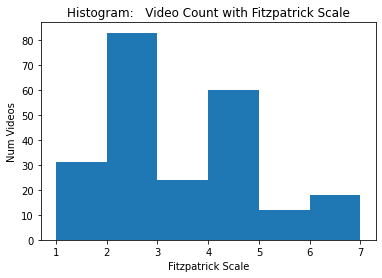

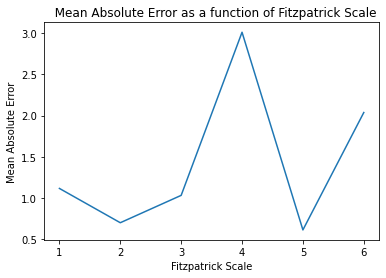

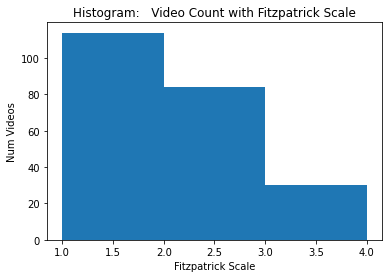

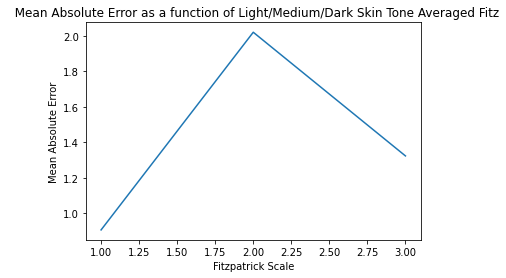

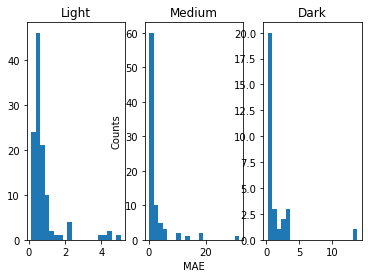

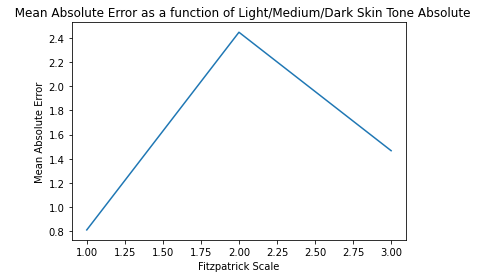

84
Mean MAE: 1.4993859649122807


[1.1141935483870964,
 0.6973493975903615,
 1.0300000000000005,
 3.012333333333333,
 0.610000000000001,
 2.036666666666666]

In [21]:
eval_model_fitz(fitz_labels_path, maes_test, test, " ")